In [1]:
# pip install aind_dynamic_foraging_basic_analysis

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
# from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re

In [3]:
# # Load behavior data

# # get list of available sessions
# file_pattern = "*.nwb"
# nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
# file_list = glob.glob(os.path.join(nwb_folder + "/" + file_pattern))
# file_names = [os.path.basename(file) for file in file_list]
# # file_name = file_names[20]

# def parseSessionID(file_name):
#     if len(re.split('[_.]', file_name)[0]) == 6:
#         aniID = re.split('[_.]', file_name)[0]
#         date = re.split('[_.]', file_name)[1]
#         dateObj = datetime.strptime(date, "%Y-%m-%d")
#     else:
#         aniID = None
#         dateObj = None
    
#     return aniID, dateObj
    
# results = [parseSessionID(file_name) for file_name in file_names]
# aniIDs, dates = zip(*results)

# sessionInfo = pd.DataFrame({'sessionID': file_names,
#                             'aniID': aniIDs,
#                             'date': dates})
# #select animal
# anim_name = '716325'
# anim_inx = sessionInfo['aniID'] == anim_name
# sessionInfo_anim = sessionInfo[anim_inx]
# # sessionInfo_anim

# #select date
# session_date = '05-31-2024'
# date_inx = sessionInfo_anim['date'] == session_date
# sessionInfo_anim_date = sessionInfo_anim[date_inx]
# # sessionInfo_anim_date
# #get nwb
# session_id = sessionInfo_anim_date['sessionID'].values[0]

# nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
# nwb_file = f"{nwb_folder}/{session_id}"
# nwb = load_nwb(nwb_file)
# nwb

In [4]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv
keypoint_dfs = load_keypoints_from_csv('/root/capsule/data/matt_test_DLC_LP_results_20240920/outputs/video_preds3/bottom_camera.csv')
print(keypoint_dfs.keys())
# keypoint_dfs

#get original video csv
video_csv = pd.read_csv('/root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv', names = ['Behav_Time','Frame','Camera_Time','Gain','Exposure'])

#assert timebase
def trim_kinematics_timebase_to_match(keypoint_dfs,video_csv):
    """
    trims lightning pose keypoints dataframe OR video csv timebase array to match in length for further processing
    NB: assumes both data structures start at beginning and are aligned
    TODO: figure out why video has one more frame than csv file

    Parameters:
    - keypoint_dfs: dataframe from load_keypoints_from_csv
    - video_csv: csv file from original bonsai video acquisition

    Returns:
    - keypoint_dfs_trimmed: trimmed if longer than video_csv, otherwise unchanged
    - video_csv_trimmed: timebase for kinematics data, in time aligned to nwb time. trimmed if longer than keypoint_dfs
    """

    LP_samples = len(keypoint_dfs[list(keypoint_dfs.keys())[0]])
    video_samples = len(video_csv)
    min_samples = np.min([LP_samples,video_samples])

    video_csv_trimmed = video_csv.iloc[:min_samples]
    keypoint_dfs_trimmed = keypoint_dfs.copy()
    for key in keypoint_dfs.keys():
        keypoint_dfs_trimmed[key] = keypoint_dfs[key].iloc[:min_samples]
    
    return keypoint_dfs_trimmed, video_csv_trimmed
keypoint_dfs_trimmed, video_csv_trimmed = trim_kinematics_timebase_to_match(keypoint_dfs,video_csv)
keypoint_timebase = video_csv_trimmed['Behav_Time']


/root/capsule/code/tongue_kinematics_utils.py:217: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv)


dict_keys(['nose_tip', 'tongue_tip', 'jaw', 'pointer_finger_l', 'pointer_finger_r', 'spout_l', 'spout_r'])


In [5]:
#extract tongue dataframe and mask
from tongue_kinematics_utils import mask_keypoint_data
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip',confidence_threshold=0.8)
tongue_masked.insert(0,'time',keypoint_timebase)


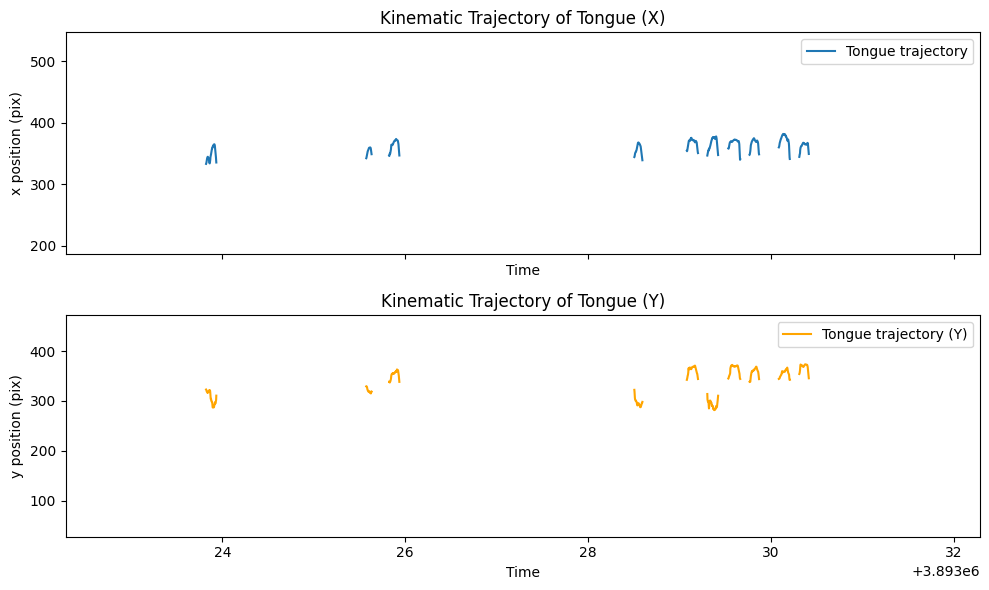

In [6]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6),sharex=True)

# First subplot
axs[0].plot(tongue_masked['time'], tongue_masked['x'], linestyle='-', label='Tongue trajectory')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x position (pix)')
axs[0].set_title('Kinematic Trajectory of Tongue (X)')
axs[0].legend()

# Second subplot
axs[1].plot(tongue_masked['time'], tongue_masked['y'], linestyle='-', label='Tongue trajectory (Y)', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('y position (pix)')
axs[1].set_title('Kinematic Trajectory of Tongue (Y)')
axs[1].legend()

time_len = 10
start_time = 100

plt.setp(axs,xlim = [tongue_masked['time'][0]+start_time, tongue_masked['time'][0]+start_time+time_len])
# Adjust layout
plt.tight_layout()
plt.show()


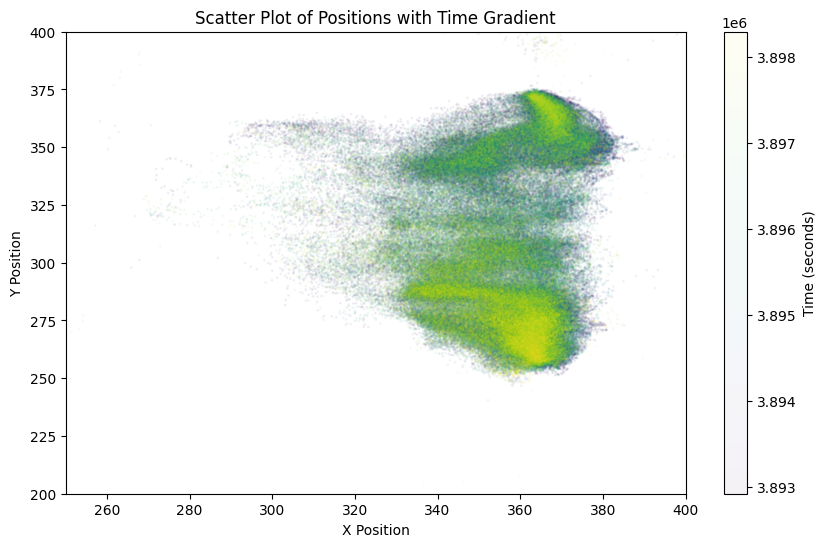

In [7]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(tongue_masked['x'], tongue_masked['y'], c=tongue_masked['time'], cmap='viridis', s=1, alpha=0.05)
plt.colorbar(sc, label='Time (seconds)')
plt.title('Scatter Plot of Positions with Time Gradient')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.xlim(250,400)
plt.ylim(200,400)
plt.show()

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=tongue_masked['x'], y=tongue_masked['y'], cmap='viridis', fill=True, thresh=0, levels=10)
plt.title('Heatmap of Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()